In [29]:
import numpy as np
from numpy import genfromtxt
from numpy import linalg as LA
from pymcmcstat.MCMC import MCMC
import pymcmcstat
from scipy.optimize import curve_fit
import mcmcplot.mcmatplot as mcmpl
import mcmcplot.mcseaborn as mcsbn
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
sns.set(font_scale=1.6)
sns.set_style("white")

dbdata = genfromtxt('db_data.txt', delimiter='')
re = dbdata[:,0]
pr = dbdata[:,1]
nu = dbdata[:,2]
theta_nom = [0.023,0.8,0.4]

def nu_f(redata,prdata,theta):
    result = theta[0]*redata**theta[1]*prdata**theta[2]
    return result

def ssfun(theta,data):
    nudata = data.ydata[0]
    redata = data.xdata[0]
    prdata = data.user_defined_object[0]
    res = nudata - nu_f(redata,prdata,theta)
    return (res**2).sum(axis=0)

def d1_c(redata,prdata,theta,h):
    theta_deriv = [theta[0]+1j*h,theta[1],theta[2]]
    return np.imag(nu_f(redata,prdata,theta_deriv))/h

def d2_c(redata,prdata,theta,h):
    theta_deriv = [theta[0],theta[1]+1j*h,theta[2]]
    return np.imag(nu_f(redata,prdata,theta_deriv))/h

def d3_c(redata,prdata,theta,h):
    theta_deriv = [theta[0],theta[1],theta[2]+1j*h]
    return np.imag(nu_f(redata,prdata,theta_deriv))/h

def sensmat(redata,prdata,theta):
    h = 1e-13
    return np.column_stack((d1_c(redata,prdata,theta,h),d2_c(redata,prdata,theta,h),d3_c(redata,prdata,theta,h)))



In [30]:
khi = np.asmatrix(sensmat(re,pr,theta_nom))
khi_t = np.transpose(khi)
multi = khi_t*khi
print(multi)
theeigs = LA.eig(multi)
print(theeigs)
mult_inv = np.linalg.inv(multi)
R = np.transpose(np.asmatrix(nu)) - np.transpose(np.asmatrix(nu_f(re,pr,theta_nom)))
sigma22 = float(1/53*np.transpose(R)*R)
V = sigma22*mult_inv
print(sigma22)
print(V)

[[2.51445943e+09 5.43034809e+08 2.20352100e+08]
 [5.43034809e+08 1.18216930e+08 4.65124030e+07]
 [2.20352100e+08 4.65124030e+07 2.13910808e+07]]
(array([2.65106433e+09, 2.78255425e+05, 2.72486108e+06]), matrix([[-0.97389177, -0.22441338,  0.03425563],
        [-0.21036638,  0.83542622, -0.50774897],
        [-0.08532761,  0.50169878,  0.86082375]]))
760.0779082737996
[[ 0.00013817 -0.00051691 -0.00029929]
 [-0.00051691  0.0019784   0.00102298]
 [-0.00029929  0.00102298  0.00089425]]


In [31]:
mcstat = MCMC()
mcstat.data.add_data_set(
    x = re.tolist(),
    y = nu.tolist(),
    user_defined_object = pr.tolist(),
)
mcstat.parameters.add_model_parameter(
    name='$theta 1$',
    theta0=theta_nom[0])
mcstat.parameters.add_model_parameter(
    name='$theta 2$',
    theta0=theta_nom[1])
mcstat.parameters.add_model_parameter(
    name='$theta 3$',
    theta0=theta_nom[2])

mcstat.simulation_options.define_simulation_options(
    nsimu=15000,
    updatesigma=1,
    method='dram',
    verbosity=1,
    waitbar=1,
    qcov = V,
)
mcstat.model_settings.define_model_settings(
    sos_function=ssfun,
    sigma2=sigma22)
mcstat.run_simulation()



Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
 $theta 1$:      0.02 [     -inf,       inf] N( 0.00e+00,      inf)
 $theta 2$:      0.80 [     -inf,       inf] N( 0.00e+00,      inf)
 $theta 3$:      0.40 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 15000 of 15000 complete in 18.5 sec



------------------------------
      name:      mean       std    MC_err       tau    geweke
 $theta 1$:  4.99e-03  2.33e-03  3.09e-04    167.62      0.75
 $theta 2$:      0.98      0.04  5.74e-03    215.12      0.97
 $theta 3$:      0.41      0.02  2.94e-03    152.86      0.94
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 3.02%
Stage 2: 21.83%
Net    : 24.85% -> 3727/15000
---------------
Chain provided:
Net    : 23.32% -> 1749/7500
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


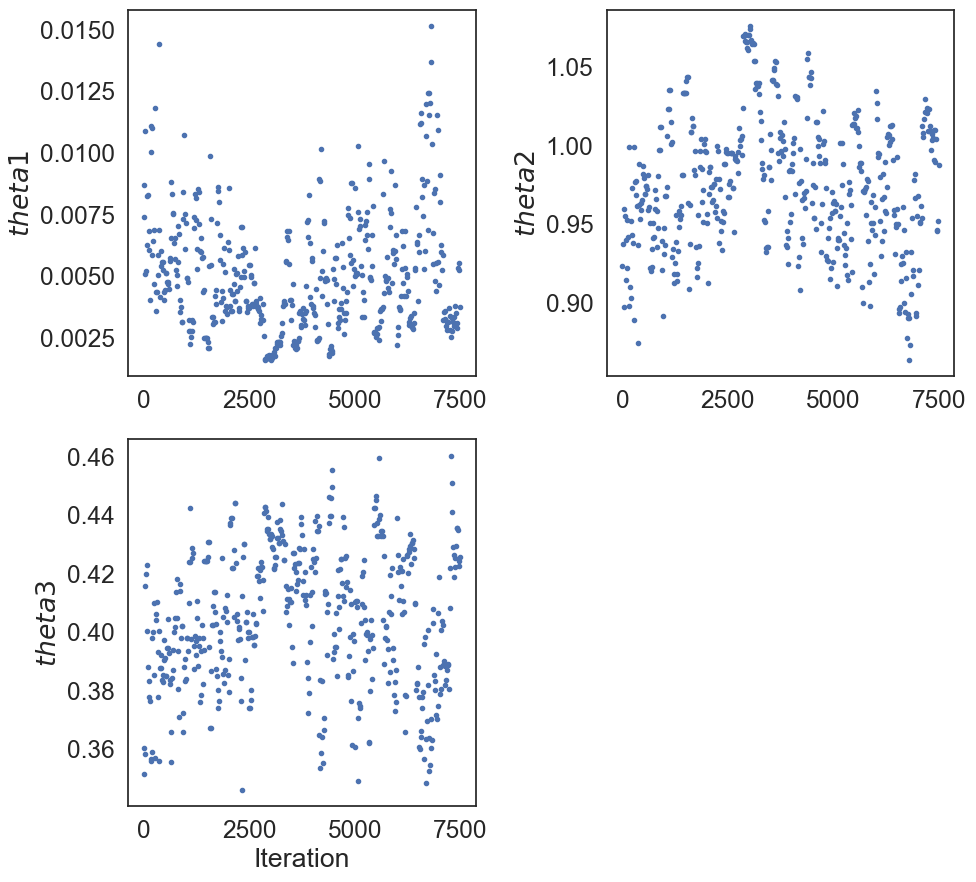

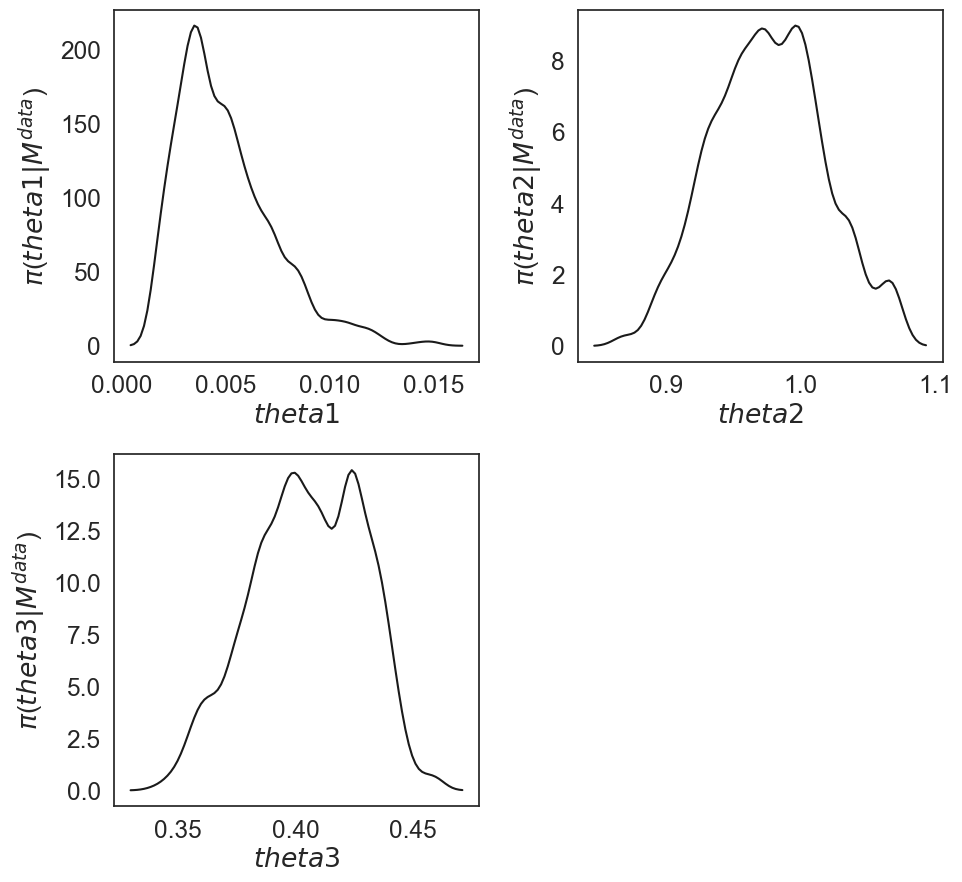

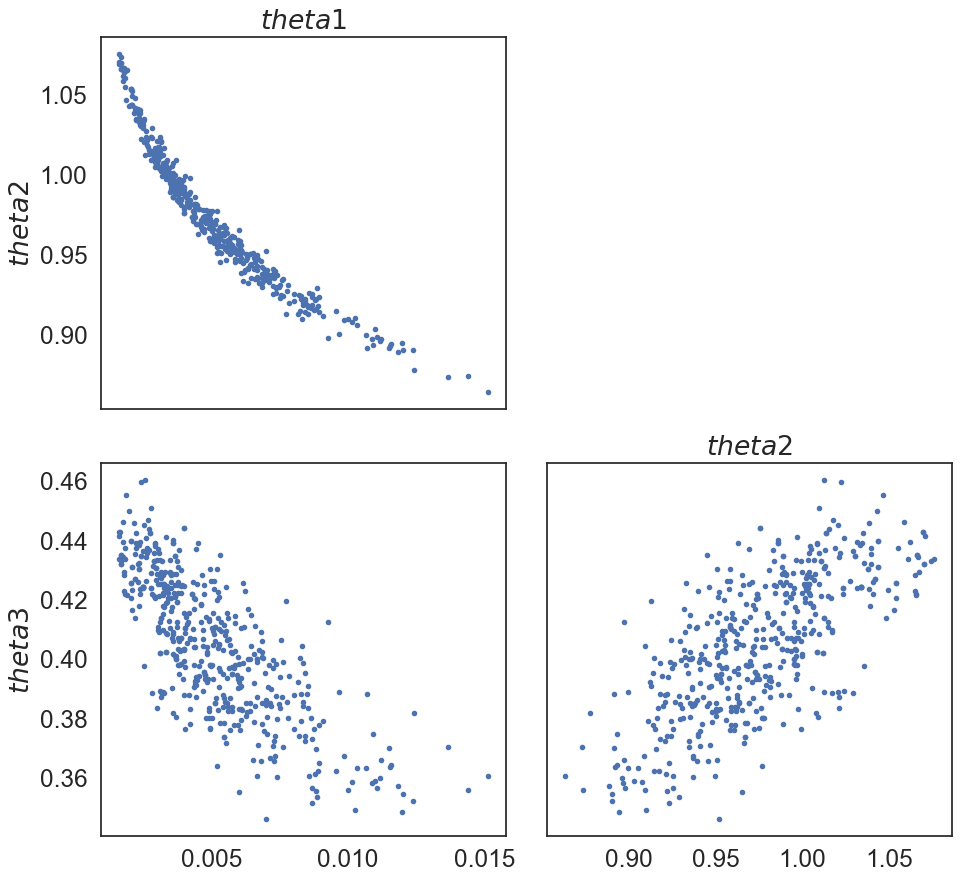

In [32]:
results = mcstat.simulation_results.results
names = results['names']
fullchain = results['chain']
fulls2chain = results['s2chain']
nsimu = results['nsimu']
burnin = int(nsimu/2)
chain = fullchain[burnin:, :]
s2chain = fulls2chain[burnin:, :]

mcstat.chainstats(chain, results)

# plot chain metrics
mcstat.mcmcplot.plot_chain_panel(chain, names, figsizeinches=(10, 10));
mcstat.mcmcplot.plot_density_panel(chain, names, figsizeinches=(10, 10));
mcstat.mcmcplot.plot_pairwise_correlation_panel(chain, names,
                                                figsizeinches=(10, 10));